In [25]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [26]:
# #Downloading TESS dataset
# !kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

In [27]:
# import zipfile
# zip_ref = zipfile.ZipFile('Dataset/archive.zip', 'r')
# zip_ref.extractall('Dataset/archive')
# zip_ref.close()

In [28]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import numpy as np
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [29]:
path = "Dataset/archive/TESS Toronto emotional speech set data/YAF_disgust/YAF_back_disgust.wav"
data, sample_rate = librosa.load(path)


In [30]:
ipd.Audio(path)

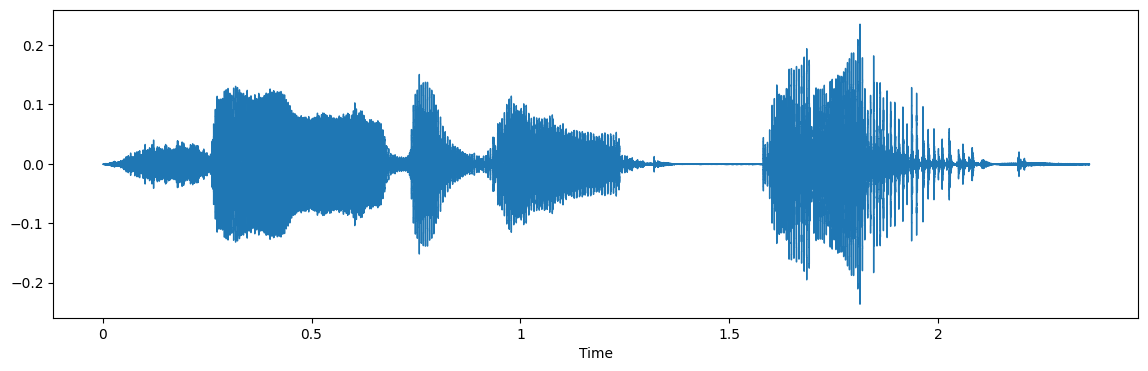

In [31]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)

In [32]:
paths = []
labels = []

for dirname, _, filenames in os.walk('Dataset/archive/TESS Toronto emotional speech set data'):
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1]
            label = label.replace('.wav', '')
            labels.append(label.lower())

    if len(paths) == 2800:
        break

print('Dataset is Loaded')


Dataset is Loaded


In [33]:
len(paths)

2800

In [34]:
labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [35]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [36]:
df = pd.DataFrame()
df['Path'] = paths
df['label'] = labels
df.head()

,Path,label
0,Dataset/archive/TESS Toronto emotional speech ...,angry
1,Dataset/archive/TESS Toronto emotional speech ...,angry
2,Dataset/archive/TESS Toronto emotional speech ...,angry
3,Dataset/archive/TESS Toronto emotional speech ...,angry
4,Dataset/archive/TESS Toronto emotional speech ...,angry


In [37]:
df['label'].value_counts()

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

In [38]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc
extract_mfcc(df['Path'][0])

array([-3.9698630e+02,  7.7440544e+01, -1.9592793e+01, -2.1666689e+01,
       -2.1127563e+00,  1.0075363e+01, -2.0366709e+01, -6.0924492e+00,
       -7.2122836e+00, -5.5736595e-01, -1.8325537e+00,  2.0210202e-01,
        7.2755092e-01,  1.3177381e+00,  2.8863375e+00,  2.8557916e+00,
       -4.7129202e+00, -4.4365101e+00, -1.6211587e+00, -1.0239840e+01,
       -7.5512633e+00, -1.7968791e+00, -7.0376520e+00,  9.4365845e+00,
        8.3558550e+00,  2.1712360e+01,  1.9216990e+01,  2.0348928e+01,
        1.3413366e+01,  8.3391733e+00,  3.9472249e-01,  5.1113148e+00,
        9.5687399e+00,  5.4548688e+00,  2.5099633e+00, -1.8239070e+00,
        4.8689623e+00,  9.3139238e+00,  2.0891497e+00, -1.9064908e+00],
      dtype=float32)

In [39]:
#Audio
extract_mfcc(df['Path'][0])
X_mfcc = df['Path'].apply(lambda x: extract_mfcc(x))
X = [x for x in X_mfcc]
X = np.array(X)
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [40]:
#Labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(512, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

c:\Users\ravi5\OneDrive\Desktop\Speech-Emotion-Recognition\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - accuracy: 0.4263 - loss: 1.4098 - val_accuracy: 0.7696 - val_loss: 0.7321
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.7290 - loss: 0.7108 - val_accuracy: 0.9232 - val_loss: 0.2404
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.8804 - loss: 0.3895 - val_accuracy: 0.9536 - val_loss: 0.1557
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.9348 - loss: 0.2445 - val_accuracy: 0.9821 - val_loss: 0.0660
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.9420 - loss: 0.2112 - val_accuracy: 0.9661 - val_loss: 0.0941
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.9464 - loss: 0.2151 - val_accuracy: 0.9732 - val_loss: 0.0956
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9616 - loss: 0.1304 - val_accuracy: 0.9607 - val_loss: 0.1322
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.9750 - loss: 0.1046 - val_accuracy: 0

In [45]:
model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9893 - loss: 0.0178


[0.01780787669122219, 0.9892857074737549]

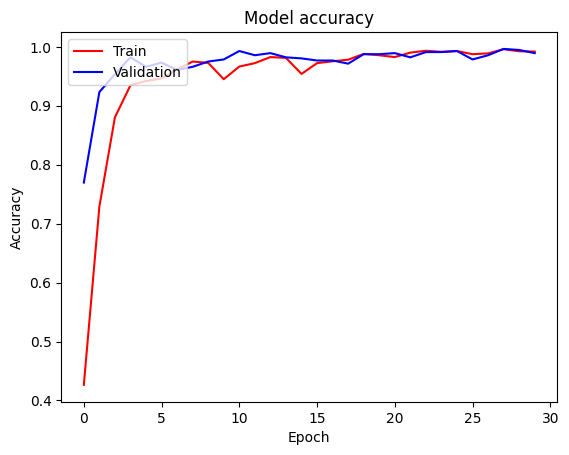

In [46]:
#Plotting  Graphs - Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

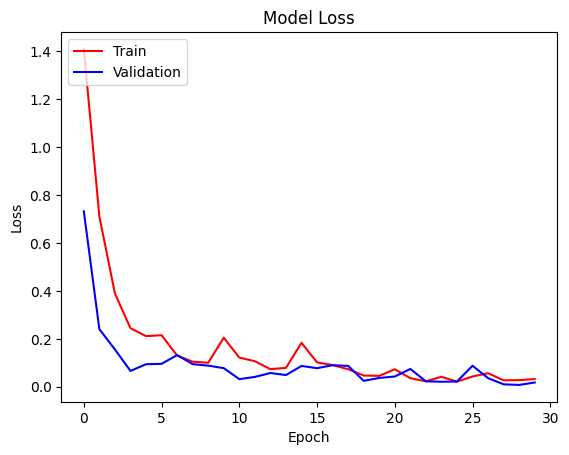

In [47]:
#Loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()